**Jairo Estefanía**

**Álvaro Sierra**

In [1]:
from scipy import signal
import numpy as np
#init_printing(use_latex=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Python no trae una función para conectar funciones de transferencia en serie o 
#retroalimentadas, asi que con ayuda del equipo de pybonacci creamos unas funciones.
#http://pybonacci.org/2013/10/10/teoria-de-control-en-python-con-scipy-i/
#http://pybonacci.org/2013/11/06/teoria-de-control-en-python-con-scipy-ii-control-pid/

def series(sys1, sys2):
    """Series connection of two systems.
    """
    if not isinstance(sys1, signal.lti):
        sys1 = signal.lti(*sys1)
    if not isinstance(sys2, signal.lti):
        sys2 = signal.lti(*sys2)
    num = np.polymul(sys1.num, sys2.num)
    den = np.polymul(sys1.den, sys2.den)
    sys = signal.lti(num, den)
    return sys
def feedback(plant, sensor=None):
    """Negative feedback connection of plant and sensor.
    If sensor is None, then it is assumed to be 1.
    """
    if not isinstance(plant, signal.lti):
        plant = signal.lti(*plant)
    if sensor is None:
        sensor = signal.lti([1], [1])
    elif not isinstance(sensor, signal.lti):
        sensor = signal.lti(*sensor)
    num = np.polymul(plant.num, sensor.den)
    den = np.polyadd(np.polymul(plant.den, sensor.den),
                     np.polymul(plant.num, sensor.num))
    sys = signal.lti(num, den)
    return sys


def error(plant, sensor=None, entrada=None):
    """Negative feedback connection of plant and sensor.
    If sensor is None, then it is assumed to be 1.
    """
    if not isinstance(plant, signal.lti):
        plant = signal.lti(*plant)

    if sensor is None:
        sensor = signal.lti([1], [1])
    elif not isinstance(sensor, signal.lti):
        sensor = signal.lti(*sensor)
        

    if entrada is None:
        entrada = signal.lti([1], [1])
    elif not isinstance(entrada, signal.lti):
        entrada = signal.lti(*entrada) 
 
        
        
 #   aux = np.polymul(plant.den, sensor.den)
    num = np.polymul(np.polymul(plant.den, sensor.den),entrada.num)
    den = np.polyadd(np.polymul(np.polymul(plant.den, sensor.den),entrada.den),
                     np.polymul(np.polymul(plant.num, sensor.num),entrada.den))
    sys = signal.lti(num, den)
    return sys


# De la misma manera, construimos una función para que nos devuelva el tiempo de 
# respuesta y el sobredisparo.

def tr(t, y, ys=None, margins=(0.0, 1.0)):
    """Rise time.
    Other possible margins: (0.05, 0.95), (0.1, 0.9). If no ys is given,
    then last value of y is assumed as stationary.
    """
    if ys is None:
        ys = y[-1]
    # Values between margins[0] * ys and margins[1] * ys
    mask = (y > margins[0] * ys) & (y < margins[1] * ys)
    # If response oscillates, only interested in limits of first region
    idx_change = np.nonzero(np.diff(mask))[0]
    # Initial and final indexes
    idx = idx_change[0], idx_change[1]
    # Time difference
    return t[idx[1]] - t[idx[0]]
def Ms(y, ys=None):
    """Maximum overshoot.
    Retorna el máximo sobreimpulso en tanto por uno.
    """
    if ys is None:
        ys = y[-1]
    ymax = np.max(y)
    Ms = (ymax - ys) / ys
    return Ms

### Representa la respuesta al sistema y la evolución del error cuando la entrada es un escalón unitario.Obten las características temporales. Representa el lugar de las raices y obtén el límite de estabilidad.

<img src="img/practica_2/sistema.svg">

In [20]:
k=([1],[1])
planta=([1],[1,3,7])
sensor=([2],[1,4])


In [21]:
proto_FTLA = series(k,planta)
FTLA = series (proto_FTLA,planta)
err = error(planta,sensor=sensor)
proto_FTLC = series (k,planta)
FTLC = feedback(proto_FTLC,sensor)

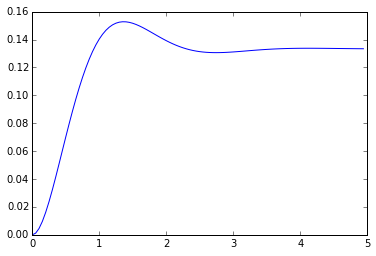

In [22]:
x1,y1 = signal.step2(FTLC)
plt.plot(x1,y1)

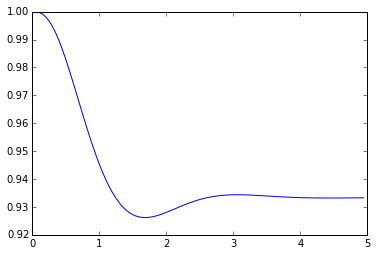

In [23]:
x1_e,y1_e = signal.step2(err)
plt.plot(x1_e,y1_e)

In [24]:
#w_la, mag_la, phase_la = signal.bode(FTLA) # Diagrama de bode: frecuencias, magnitud y fase
#w_lc, mag_lc, phase_lc = signal.bode(FTLC) 
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
#ax1.semilogx(w_la, mag_la) # Eje x logarítmico
#ax2.semilogx(w_la, phase_la) # Eje x logarítmico

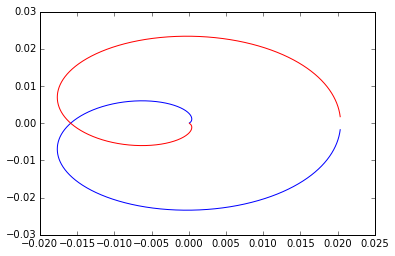

In [25]:
w,H = signal.freqresp(FTLA)
plt.figure()
plt.plot(H.real,H.imag,'b')
plt.plot(H.real, -H.imag,'r')
#plt.show()

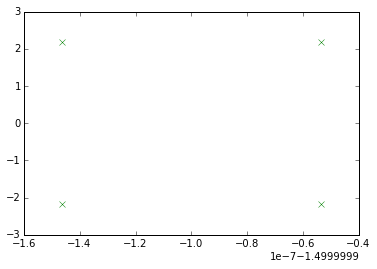

In [26]:
plt.plot(FTLA.zeros.real, FTLA.zeros.imag, 'o')
plt.plot(FTLA.poles.real, FTLA.poles.imag, 'x')

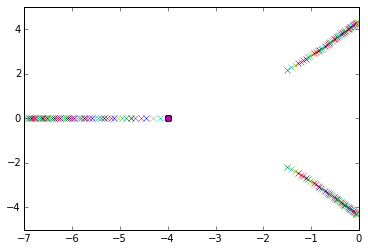

In [27]:
#Limite de estabilidad (lazo cerrado) para k=52
for i in range(0,52):
    #print(i)
    k=([i],[1])
    proto_FTLA = series(k,planta)
    proto_FTLC = series (k,planta)
    FTLC = feedback(proto_FTLC,sensor)
    plt.plot(FTLC.zeros.real, FTLC.zeros.imag, 'o')
    plt.plot(FTLC.poles.real, FTLC.poles.imag, 'x')


In [30]:
#¿Modificar funciones para valores absolutos? 

print(Ms(y1))
print(tr(x1,y1,ys=None,margins=(0,1)))


0.145106245485
0.898971313448


### 2.- Se plantea el uso de reguladores PD. En concreto el $PD_1 = 0.4(s+7)$ y el $PD_2 = 0.6(s+2)$

In [31]:
# Obtengo error al sacar el sistema de transferencia directamente de los reguladores por tener más ceros que polos.

#k=([1],[1])
#planta=([1],[1,3,7])
#sensor=([2],[1,4])

#PD1 = ([0.4, 2.8],[1])
#PD2 = ([0.6, 1.2],[1])
num_1 = np.polymul([0.4, 2.8],[1])
num1 = np.polymul(num_1,[1, 4])
#den = np.polymul([0.4],[2.8])

den1 = np.polyadd(np.polymul([1, 3, 7], [1, 4]),
                 np.polymul([0.4, 2.8],[2]))
NFTLC1 = signal.lti(num1, den1)

num_1=np.polymul([0.4,2.8],[2])
den_1 =np.polyadd([1,3,7],[1,4])
NFTLA1 =signal.lti(num_1,den_1)

num2 = np.polymul([0.6, 1.2],[1, 4])
den2 = np.polyadd(np.polymul([1,3,7], [1,4]),
                 np.polymul([0.6, 1.2],[1]))
NFTLC2 = signal.lti(num2, den2)

num_2=np.polymul([0.6,1.2],[2])
den_2 =np.polyadd([1,3,7],[1,4])
NFTLA2 = signal.lti(num_2,den_2)

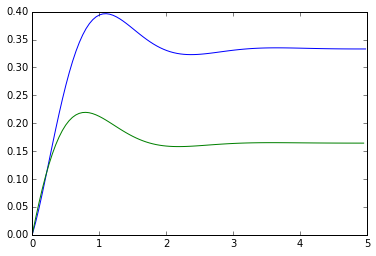

In [32]:
x1,y1 = signal.step2(NFTLC1)
x2,y2 = signal.step2(NFTLC2,T=np.arange(0,5,0.05))
plt.plot(x1,y1,'b',x2,y2,'g')

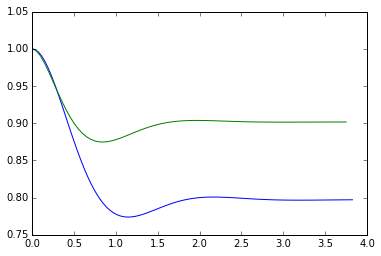

In [33]:
#Falta: [ERRORES][Lugar de las raices]
err1=error(NFTLA1,sensor)
x1,y1 = signal.step2(err1)
err2 = error(NFTLA2,sensor)
x2,y2 = signal.step2(err2,T=np.arange(0,3.8,0.05))
plt.plot(x1,y1,x2,y2)

In [34]:
OShoot1 = Ms(y1)
OShoot2 = Ms(y2)
temp1 = tr(x1,y1)
temp2 = tr(x2,y2)
print("El sobredisparo para el regulador 1 es de {:0.4}%".format(OShoot1*100))
print("El sobredisparo para el regulador 2 es de {:0.4}%".format(OShoot2*100))
print("El tiempo de respuesta [0 -> 1] del regulador 1 es de {:0.3}s.".format(temp1))
print("El tiempo de respuesta [0 -> 1] del regulador 2 es de {:0.3}s.".format(temp2))

El sobredisparo para el regulador 1 es de 25.46%
El sobredisparo para el regulador 2 es de 10.91%
El tiempo de respuesta [0 -> 1] del regulador 1 es de 1.0s.
El tiempo de respuesta [0 -> 1] del regulador 2 es de 1.2s.


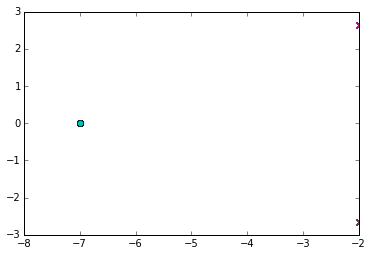

In [37]:
for i in range(0,1000):
    #print(i)
    k=[i]
 #   proto_FTLA = series(k,planta)
 #   proto_FTLC = series (k,planta)
 #   FTLC = feedback(proto_FTLC,sensor)
    num_1=np.polymul([0.4,2.8],[2])
    num1=np.polymul(num_1,k)
    den_1 =np.polyadd([1,3,7],[1,4])
    NFTLA1 =signal.lti(num1,den_1)
    plt.plot(NFTLA1.zeros.real, NFTLA1.zeros.imag, 'o')
    plt.plot(NFTLA1.poles.real, NFTLA1.poles.imag, 'x')

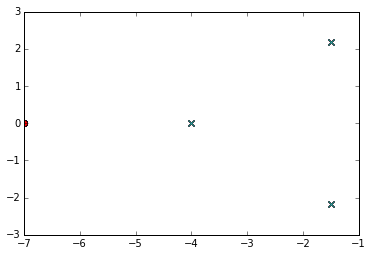

In [38]:
for i in range(0,100):
    #print(i)
    k=[i]
 #   proto_FTLA = series(k,planta)
 #   proto_FTLC = series (k,planta)
 #   FTLC = feedback(proto_FTLC,sensor)
    num_2=np.polymul([0.6,1.2],[2])
    num2=np.polymul(num_1,k)
    den_2 =np.polymul([1,3,7],[1,4])
    NFTLA2 =signal.lti(num2,den_2)
    plt.plot(NFTLA2.zeros.real, NFTLA2.zeros.imag, 'o')
    plt.plot(NFTLA2.poles.real, NFTLA2.poles.imag, 'x')

### 3.- A continuacnión se utilizan reguladores PI. Killo, ya sabes que hay que azé. ;)

In [47]:
PI1 = ([2,16],[1,0])
PI2 = ([1,5],[1,0])

In [71]:
proto_MNFTLA1 = series(PI1,planta)
proto_MNFTLA2 = series(PI2,planta)
MNFTLA1 = series(sensor,proto_MNFTLA1)
MNFTLA2 = series(sensor,proto_MNFTLA2)
#FTLA1 = ([1],np.polyadd(MNFTLA1.num,MNFTLA1.den))
#FTLA2 = ([1],np.polyadd(MNFTLA2.num,MNFTLA2.den))
err_PI_1=error(proto_MNFTLA1,sensor=sensor) #¿Correcto?
err_PI_2=error(proto_MNFTLA2,sensor=sensor) # ¿Correcto?
FTLC1 = feedback(proto_MNFTLA1,sensor)
FTLC2 = feedback(proto_MNFTLA2,sensor)

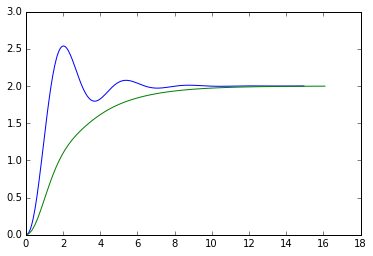

In [72]:
x1,y1 = signal.step2(FTLC1,T=np.arange(0,15,0.05))
x2,y2 = signal.step2(FTLC2)
plt.plot(x1,y1,'b',x2,y2,'g')

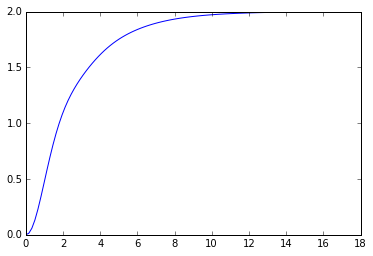

In [73]:
plt.plot(x2,y2)

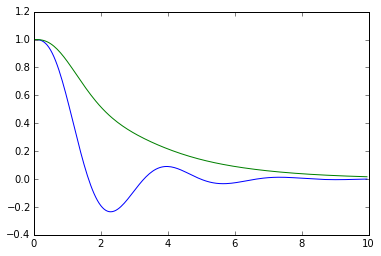

In [75]:
#err_PI_1=error(NFTLA1,sensor)
x1,y1 = signal.step2(err_PI_1,T=np.arange(0,10,0.05))
#err_PI_2 = error(NFTLA2,sensor)
x2,y2 = signal.step2(err_PI_2,T=np.arange(0,10,0.05))
#,T=np.arange(0,3.8,0.05)
plt.plot(x1,y1,x2,y2)

### 4.- Introducir conjuntamente en el sistema el controlador PI, y el PD que mejor comportamiento hayan mostrado en las fases anteriores.

In [120]:
PD1 = ([0.4, 2.8],[1])
PI1 = ([2,16],[1,0])
PID__ = series(planta, PI1)
#PID = series(PID__,PD1)

PID_num = np.polymul(PID__.num,[0.4,2.8])
PID_den = np.polymul(PID__.den,[1])
PID = signal.lti(PID_num, PID_den)
Sistema = feedback(PID,sensor)# ¿Correcto?

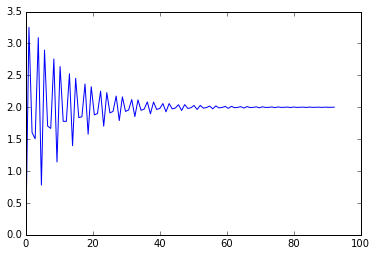

In [121]:
x1,y1 = signal.step2(Sistema)
plt.plot(x1,y1)